**[Соревнование](https://inclass.kaggle.com/c/beeline-credit-scoring-competition-2).**

Решается задача кредитного скоринга. 

Признаки клиентов банка:
- Age - возраст (вещественный)
- Income - месячный доход (вещественный)
- BalanceToCreditLimit - отношение баланса на кредитной карте к лимиту по кредиту (вещественный)
- DIR - Debt-to-income Ratio (вещественный) Отношение крединых обязтельст к доходу
- NumLoans - число заемов и кредитных линий
- NumRealEstateLoans - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- NumDependents - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- Num30-59Delinquencies - число просрочек выплат по кредиту от 30 до 59 дней (натуральное число)
- Num60-89Delinquencies - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)
- Delinquent90 - были ли просрочки выплат по кредиту более 90 дней (бинарный) - имеется только в обучающей выборке

*Лимиту по кредиту - максимальный предел предоставляемого кредита.

In [20]:
#import warnings
#warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
%pylab inline

Populating the interactive namespace from numpy and matplotlib


c:\python27\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes', 'f', 'fmin']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


**Загружаем данные.**

In [235]:
train_df = pd.read_csv('credit_scoring_train.csv', index_col='client_id')
test_df = pd.read_csv('credit_scoring_test.csv', index_col='client_id')

In [231]:
y = train_df['Delinquent90']
train_df.drop('Delinquent90', axis=1, inplace=True)

**Заменим пропуски медианными значениями.**

In [236]:
train_df['NumDependents'].fillna(train_df['NumDependents'].median(), inplace=True)
train_df['Income'].fillna(train_df['Income'].median(), inplace=True)
test_df['NumDependents'].fillna(test_df['NumDependents'].median(), inplace=True)
test_df['Income'].fillna(test_df['Income'].median(), inplace=True)

In [242]:
train_df.head(10).T

client_id,0,1,2,3,4,5,6,7,8,9
DIR,0.496289,0.433567,2206.731199,886.132793,0.000000,0.121965,0.461193,2.624982,0.074518,0.266679
Age,49.100000,48.000000,55.500000,55.300000,52.300000,73.500000,71.300000,46.300000,28.100000,31.300000
NumLoans,13.000000,9.000000,21.000000,3.000000,1.000000,18.000000,9.000000,6.000000,10.000000,6.000000
NumRealEstateLoans,0.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
NumDependents,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
Num30-59Delinquencies,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Num60-89Delinquencies,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Income,5298.360639,6008.056256,5424.552473,5424.552473,2504.613105,15634.752299,3562.767475,2205.386980,5021.722284,4005.890242
BalanceToCreditLimit,0.387028,0.234679,0.348227,0.971930,1.004350,0.004951,0.039618,0.846364,0.048213,0.366262
Delinquent90,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [84]:
train_df['Age'].corr(train_df['Delinquent90'])

-0.11419134758200156

In [221]:
train_df[train_df['DIR']==0]['DIR'].count()

2090

In [241]:
train_df['ClientRate'] = train_df['Num30-59Delinquencies']+train_df['Num30-59Delinquencies']

In [173]:
train_df['DIR'].describe()

count     75000.000000
mean        353.260293
std        2117.237432
min           0.000000
25%           0.176022
50%           0.366848
75%           0.862650
max      332600.272820
Name: DIR, dtype: float64

In [237]:
train_df['DIR_binar']= train_df['DIR'].apply(lambda x: 1 if x>0 else 0)

In [240]:
train_df.groupby('DIR_binar').sum()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
DIR_binar,,,,,,,,,,
0,0.000000e+00,1.092983e+05,4649,0,595.0,10596,10544,1.006902e+07,946.542985,176
1,2.649452e+07,3.835372e+06,629083,76252,54654.0,21528,8056,4.759041e+08,469768.190824,4837


In [243]:

train_df[(train_df['NumLoans']>0) & (train_df['DIR'] ==0)]['DIR'] = train_df['DIR'].mean()


c:\python27\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [86]:
train_df['Num30-59Delinquencies']=train_df['Num30-59Delinquencies'].\
                            apply(lambda x: 0 if x > 20 else x)

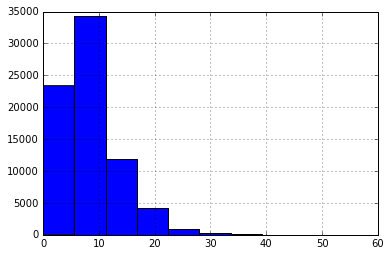

In [91]:
train_df['NumLoans'].hist()

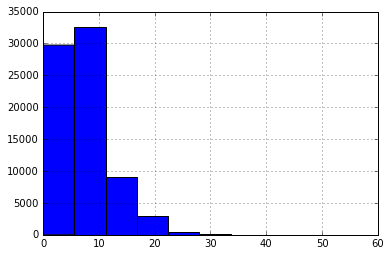

In [92]:
(train_df['NumLoans'] - train_df['NumRealEstateLoans']).hist()

**Запиcь прогноз в файл.**

In [6]:
def write_to_submission_file(predicted_labels, out_file,
                             target='Delinquent90', index_label="client_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(75000, 
                                                  predicted_labels.shape[0] + 75000),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

### Случайный лес с подбором параметров

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [10]:
forest_param = [{'n_estimators': list(range(10,11)),\
                 'max_depth': list(range(3,10)),\
                 'min_samples_leaf': list(range(3,8))}]
forest = GridSearchCV(RandomForestClassifier(), forest_param, cv=5, scoring='roc_auc')
forest.fit(train_df, y)
forest_prob = forest.predict_proba(test_df)[:, 1]

In [11]:
forest.score(train_df,y)

0.86203885814125059

In [12]:
forest.best_params_

{'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 10}

In [17]:
fin_forest = RandomForestClassifier(max_depth= 8, min_samples_leaf= 3, n_estimators = 10)
fin_forest.fit(train_df,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
pd.DataFrame(fin_forest.feature_importances_, columns=['Importance'],
             index=train_df.columns).sort_values(by='Importance', ascending=False)

,Importance
BalanceToCreditLimit,0.306165
Num30-59Delinquencies,0.239954
Num60-89Delinquencies,0.216132
Age,0.063068
NumLoans,0.051821
DIR,0.048699
Income,0.042148
NumRealEstateLoans,0.019457
NumDependents,0.012556


In [14]:
write_to_submission_file(forest_prob, 'credit_scoring_final_forest.csv')

## Градиентный бустинк с подбором пораметров

In [24]:
import xgboost as xgb

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.cross_validation import KFold, train_test_split,cross_val_score
from sklearn.metrics import log_loss

In [25]:
def score(params):
    from sklearn.metrics import log_loss
    print("Training with params:")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    # watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid).reshape((X_test.shape[0], 2))
    score = log_loss(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}


def optimize(trials):
    space = {
             'n_estimators' : 150,
             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
             'max_depth' : hp.choice('max_depth', range(1,20)),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.25),
             'gamma' : 0,
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.25),
             'num_class' : 2,
             'eval_metric': 'merror',
             'objective': 'multi:softprob',
             'nthread' : 4,
             'silent' : 1
             }
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=50)

    print(best)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=666)

#Trials object where the history of search will be stored
trials = Trials()
optimize(trials)

Training with params:
{'colsample_bytree': 0.75, 'silent': 1, 'eval_metric': 'merror', 'nthread': 4, 'min_child_weight': 2.0, 'n_estimators': 150, 'subsample': 0.75, 'eta': 0.275, 'objective': 'multi:softprob', 'num_class': 2, 'max_depth': 3, 'gamma': 0}
	Score 0.183071568043


Training with params:
{'colsample_bytree': 0.75, 'silent': 1, 'eval_metric': 'merror', 'nthread': 4, 'min_child_weight': 5.0, 'n_estimators': 150, 'subsample': 0.5, 'eta': 0.30000000000000004, 'objective': 'multi:softprob', 'num_class': 2, 'max_depth': 3, 'gamma': 0}
	Score 0.183414130268


Training with params:
{'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'merror', 'nthread': 4, 'min_child_weight': 1.0, 'n_estimators': 150, 'subsample': 0.75, 'eta': 0.1, 'objective': 'multi:softprob', 'num_class': 2, 'max_depth': 4, 'gamma': 0}
	Score 0.181526414134


Training with params:
{'colsample_bytree': 0.75, 'silent': 1, 'eval_metric': 'merror', 'nthread': 4, 'min_child_weight': 2.0, 'n_estimators': 150, 'subsa

0 max_depth
1 eta
2 min_child_weight
3 subsample


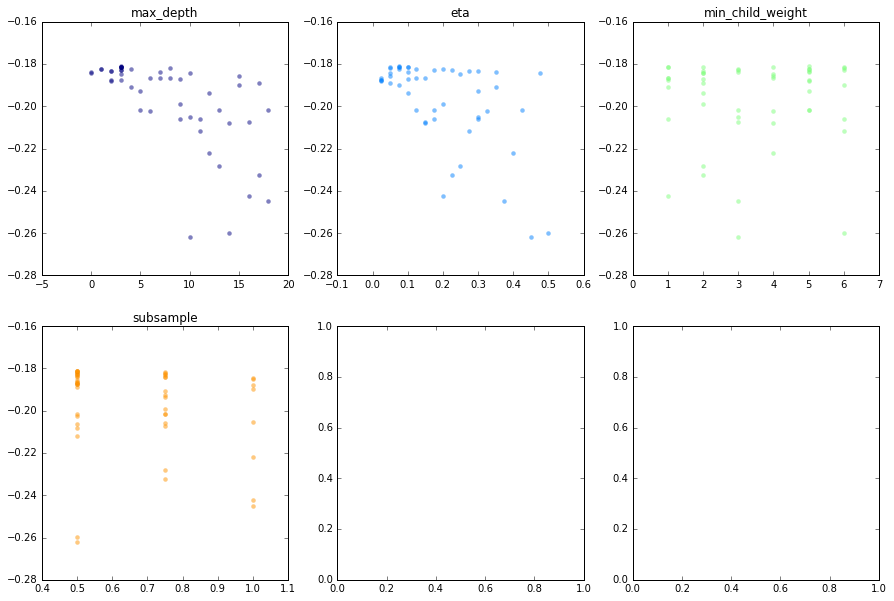

In [27]:
parameters = ['max_depth', 'eta', 'min_child_weight', 'subsample'] 
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    print i, val
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i/3,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i/3,i%3].set_title(val)
    #axes[i/3,i%3].set_ylim([0.9,1.0])

In [61]:
param = {'subsample': 0.5, 'eta': 0.07500000000000001, 'colsample_bytree': 0.5, 'max_depth': 3, 'min_child_weight': 5.0}

In [65]:
dtrain = xgb.DMatrix(train_df, y)
xgbCvResult = xgb.cv(param, dtrain, 
                      num_boost_round=250,  
                      nfold=5)

In [69]:
xgbCvResult.columns

Index([u'test-rmse-mean', u'test-rmse-std', u'train-rmse-mean',
       u'train-rmse-std'],
      dtype='object')

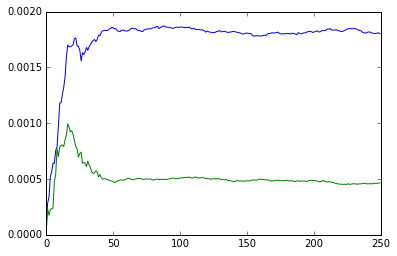

In [73]:
plot(range(xgbCvResult.shape[0]), xgbCvResult['test-rmse-std'])
plot(range(xgbCvResult.shape[0]), xgbCvResult['train-rmse-std'])

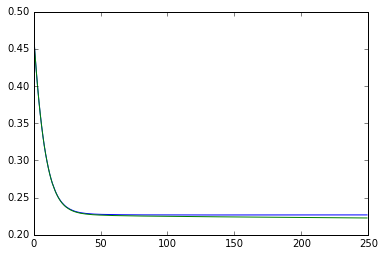

In [72]:
plot(range(xgbCvResult.shape[0]), xgbCvResult['test-rmse-mean'])
plot(range(xgbCvResult.shape[0]), xgbCvResult['train-rmse-mean'])

In [75]:
best_num_round = np.argmin(xgbCvResult['test-rmse-mean'])
best_num_round

117

In [76]:
bestXgb = xgb.train(param, dtrain, 750)

In [77]:
dtest = xgb.DMatrix(test_df)

In [84]:
xgboost_predict_proba = bestXgb.predict(dtest)
xgboost_predict_proba 

array([ 0.03451559,  0.58723229,  0.0185234 , ...,  0.07568908,
        0.00668788,  0.07508883], dtype=float32)

In [89]:
write_to_submission_file(xgboost_predict_proba, 
                         'forest_cover_type_xgboost.csv')

## Комбинированная проверка

In [10]:
def hyperopt_train_test(params):
    t = params['type']
    del params['type']
    if t == 'forest':
        clf = RandomForestClassifier(**params)
    elif t == 'knn':
        clf = KNeighborsClassifier(**params)
    else:
        return 0
    return cross_val_score(clf, train_df, y).mean()

space = hp.choice('classifier_type', [
    {
        'type': 'forest',
        'max_depth': hp.choice('max_depth', range(1,20)),
        'max_features': hp.choice('max_features', range(1,9)),
        'n_estimators': hp.choice('n_estimators', range(10,20)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
    },
    {
        'type': 'knn',
        'n_neighbors': hp.choice('knn_n_neighbors', range(1,50))
    }
])

count = 0
best = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params.copy())
    if acc > best:
        print 'new best:', acc, 'using', params['type']
        best = acc
    if count % 50 == 0:
        print 'iters:', count, ', acc:', acc, 'using', params
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=1500, trials=trials)
print 'best:'
print best

new best: 0.9332 using forest
new best: 0.933266666667 using knn
new best: 0.934466666667 using forest
new best: 0.934586666667 using forest
new best: 0.934866666667 using forest
new best: 0.93488 using forest
new best: 0.93492 using forest
new best: 0.935426666667 using forest
iters: 50 , acc: 0.931906666667 using {'max_features': 4, 'n_estimators': 11, 'criterion': 'entropy', 'max_depth': 19, 'type': 'forest'}
iters: 100 , acc: 0.934213333333 using {'max_features': 3, 'n_estimators': 6, 'criterion': 'entropy', 'max_depth': 8, 'type': 'forest'}
iters: 150 , acc: 0.934906666667 using {'max_features': 2, 'n_estimators': 18, 'criterion': 'gini', 'max_depth': 8, 'type': 'forest'}
iters: 200 , acc: 0.93028 using {'max_features': 1, 'n_estimators': 1, 'criterion': 'gini', 'max_depth': 9, 'type': 'forest'}
iters: 250 , acc: 0.93316 using {'n_neighbors': 30, 'type': 'knn'}
iters: 300 , acc: 0.933173333333 using {'n_neighbors': 31, 'type': 'knn'}
iters: 350 , acc: 0.931813333333 using {'max_fe

In [ ]:
parameters = ['n_estimators', 'max_depth', 'max_features', 'criterion']
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    print i, val
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i/3,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i/3,i%3].set_title(val)
    #axes[i/3,i%3].set_ylim([0.9,1.0])